# Capstone Supplementary EDA: Modelling Decade-Defining Topics

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
df = pd.read_pickle("/Users/anastasiakuzmich/Desktop/Capstone Data/final_springer_nature.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103985 entries, 0 to 104460
Data columns (total 30 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   doi               103985 non-null  object 
 1   title             103985 non-null  object 
 2   journal           103985 non-null  object 
 3   year_published    103985 non-null  int64  
 4   first_author      103985 non-null  object 
 5   second_author     103985 non-null  object 
 6   third_author      103985 non-null  object 
 7   author_count      103985 non-null  int64  
 8   genre             103985 non-null  int64  
 9   publisher         103985 non-null  int64  
 10  issue_type        103985 non-null  float64
 11  article_length    103985 non-null  float64
 12  is_open_access    103985 non-null  int64  
 13  keywords          103985 non-null  object 
 14  abstract          103985 non-null  object 
 15  article_accesses  103985 non-null  float64
 16  web_of_science    10

In [3]:
def restructure_capstone_dataset(df):
    
    "Restructures the dataset into the desired format for modelling"
    
    df.columns = [x.lower().replace('article_accesses', 'view_count') for x in df.columns]
    df.columns = [x.lower().replace('cross_ref', 'value_factor') for x in df.columns]
    
    df =  make_impact_factor_column(df)
    df = make_time_period_column(df)
    
    return df
    
def make_time_period_column(df):
    
    "Adds a time period column to the dataframe."
    
    df["time_period"] = df["year_published"].apply(lambda year: map_period(year))
    
    return df

def map_period (year):
    
    "Maps the time periods given the publication year."
    
    if year < 1970:
        return 1900
    elif year < 1980:
        return 1970
    elif year < 1990:
        return 1980
    elif year < 2000:
        return 1990
    elif year < 2010:
        return 2000
    elif year < 2020:
        return 2010
    else:
        return 2020 
    
def make_impact_factor_column(df):
    
    "Calculates the impact factor from the metrics columns of a dataframe & drops them"
    
    df["impact_factor"] = df["web_of_science"] * 0 + df["mendeley"] * 0 + df["citeulike"] * 0 \
    + df["twitter"] * 0.25 + df["facebook"] * 0.25 + df["reddit"] * 0.25 + df["pinterest"] * 0.25 \
    + df["video"] * 0.25 + df["google_plus"] * 1 + df["f1000"] * 1 + df["wiki"] * 3 + df["blogs"] * 5 \
    + df["news"] * 8
    
    drop_columns = ['web_of_science', 'twitter', 'facebook', 'blogs', 'google_plus', 'news', 
                    'reddit','f1000','pinterest', 'video', 'mendeley', 'wiki', 'citeulike']

    for column in drop_columns:
        df = df.drop(column, axis=1)
    
    return df

# Preprocessing

## Cleaning & restructuring

In [4]:
df = restructure_capstone_dataset(df=df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103985 entries, 0 to 104460
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   doi             103985 non-null  object 
 1   title           103985 non-null  object 
 2   journal         103985 non-null  object 
 3   year_published  103985 non-null  int64  
 4   first_author    103985 non-null  object 
 5   second_author   103985 non-null  object 
 6   third_author    103985 non-null  object 
 7   author_count    103985 non-null  int64  
 8   genre           103985 non-null  int64  
 9   publisher       103985 non-null  int64  
 10  issue_type      103985 non-null  float64
 11  article_length  103985 non-null  float64
 12  is_open_access  103985 non-null  int64  
 13  keywords        103985 non-null  object 
 14  abstract        103985 non-null  object 
 15  view_count      103985 non-null  float64
 16  value_factor    103985 non-null  float64
 17  impact_fac

In [5]:
convert_to_16bit = ["year_published", "author_count", "genre", "publisher", "issue_type", 
                   "article_length", "time_period"]


for column in convert_to_16bit:
    df[column] = df[column].astype('float16')
    
convert_to_32bit = ["view_count", "value_factor", "impact_factor"]

for column in convert_to_32bit:
    df[column] = df[column].astype('float32')

In [6]:
df = df.drop("doi", axis=1)
df = df.drop("second_author", axis=1)
df = df.drop("third_author", axis=1)
df = df.drop("keywords", axis=1)
df = df.drop("title", axis=1)

In [7]:
df = df[df["time_period"] != 1900.0]
df["time_period"].value_counts()

2010.0    44803
2000.0    20608
2020.0    17589
1990.0     9439
1980.0     6666
1970.0     4000
Name: time_period, dtype: int64

## Encoding decades

In [8]:
def encode_decades(time_period):
    
    "Encodes the decades"
    
    if time_period == 1970.0:
        return 0
    elif time_period == 1980.0:
        return 1
    elif time_period == 1990.0:
        return 2
    elif time_period == 2000.0:
        return 3
    elif time_period == 2010.0:
        return 4
    else: 
        return 5

In [9]:
df = df[["time_period", "abstract"]]

In [10]:
df["decade_class"] = df["time_period"].apply(lambda time_period: encode_decades(time_period))

In [11]:
df["decade_class"].value_counts()

4    44803
3    20608
5    17589
2     9439
1     6666
0     4000
Name: decade_class, dtype: int64

## Establishing target & predictors

In [12]:
y = df.pop("decade_class")
X = df

In [13]:
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(random_state=42)
X, y = undersampler.fit_resample(X, y)

y.value_counts()

0    4000
1    4000
2    4000
3    4000
4    4000
5    4000
Name: decade_class, dtype: int64

**Baseline prediction:**

In [14]:
print("My baseline prediction is", y.value_counts(normalize=True).max())

My baseline prediction is 0.16666666666666666


## Lemmatisation

In [15]:
from nltk.stem.wordnet import WordNetLemmatizer

def lemmatise_sentences(sentence):
    
    "Lemmatises words within a sentence."
    
    lemmatiser = WordNetLemmatizer()
    words = sentence.split()
    lemmatised_tokens = [lemmatiser.lemmatize(word) for word in words]
    return ' '.join(lemmatised_tokens)

In [17]:
df["abstract"] = df["abstract"].apply(lemmatise_sentences) 

## Train-test split

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
del X, y

(19200, 2) (19200,) (4800, 2) (4800,)


## Frequency-vectorising

In [19]:
train_topics = X_train.pop("abstract")
test_topics = X_test.pop("abstract")

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

exclude = ["key", "words", "keywords", "fig", "study", "authors", "pages", "discussed", "using", "figs",
          "suggested", "abstract", "based", "via", "show", "conclusion", 
           "discussion", "methods", "results", "aimed", "made", "conclusions", 
           "outcomes", "key", "words", "keywords", 'any','apply','applying',
           'reapplying','given','papers','paper','about','results','result',
           'real','world','page','article','present','takes','account', 
           'previous','work','propose','proposes','proposed','simply',
           'simple','demonstrate','demonstrated','demonstrates','realworld',
           'datasets','dataset','provide','important','research','researchers',
           'experiments','experiment','unexpected','discovering','using','recent',
           'collected','solve','columns','existing','traditional','final','consider',
           'presented','provides','automatically','extracting','including','help','helps',
           'explore','illustrate','achieve','better']

my_stop_words = list(stopwords.words('english'))

for word in exclude:
    my_stop_words.append(word)
    
print(len(my_stop_words))

263


In [22]:
tvec = TfidfVectorizer(stop_words=my_stop_words, 
                       encoding='utf-8', 
                       strip_accents='ascii', 
                       ngram_range=(1,2))

tvec.fit(train_topics)

tvec_matrix_train = tvec.transform(train_topics)
tvec_matrix_test = tvec.transform(test_topics)

In [23]:
feature_names = list(tvec.get_feature_names_out())

In [24]:
X_train = tvec_matrix_train
X_test = tvec_matrix_test

In [25]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(19200, 1460279) (19200,) (4800, 1460279) (4800,)


In [26]:
del train_topics, test_topics

# Model Fitting

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=21)

lasso = LogisticRegressionCV(penalty='l2',
                             solver='saga',
                             max_iter = 1000,
                             Cs=np.logspace(-4, 4, 30),
                             cv=kf)

lasso.fit(X_train, y_train)

In [39]:
print('BEST ALPHA:', lasso.C_)

BEST ALPHA: [1487.35210729 1487.35210729 1487.35210729 1487.35210729 1487.35210729
 1487.35210729]


In [27]:
from sklearn.linear_model import LogisticRegression

lasso = LogisticRegression(penalty='l2',
                           solver='saga',
                           max_iter = 1000,
                           C=1487.35210729)

lasso.fit(X_train, y_train)

LogisticRegression(C=1487.35210729, max_iter=1000, solver='saga')

In [28]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=21)

import warnings 
with warnings.catch_warnings():
    
    warnings.simplefilter("ignore")
    cv_scores =  cross_val_score(lasso, X_train, y_train, cv=kf)

print("BEST TRAIN SCORE:", lasso.score(X_train, y_train),
      "\nBEST TEST SCORE:", lasso.score(X_test, y_test),
      "\nBEST MEAN CV SCORE:", cv_scores.mean(),
      "\nBEST CV STD:", cv_scores.var())

BEST TRAIN SCORE: 1.0 
BEST TEST SCORE: 0.5085416666666667 
BEST MEAN CV SCORE: 0.49057291666666664 
BEST CV STD: 4.934353298611159e-06


## Extracting Feature Coefficients

In [29]:
decade_coefficients = pd.DataFrame({'feature': feature_names,
                                    '70s': lasso.coef_[0],
                                    '80s': lasso.coef_[1],
                                    '90s': lasso.coef_[2],
                                    '00s': lasso.coef_[3],
                                    '10s': lasso.coef_[4],
                                    '20s': lasso.coef_[5]})

decade_coefficients.head(30)

feature       70s       80s       90s       00s       10s       20s
0        00 -3.306035  1.135269  1.587807 -0.787634  1.397581 -0.026989
1     00 00 -0.176209 -0.790891  1.287983 -0.128664 -0.364329  0.172110
2    00 000 -0.000556 -0.002234 -0.035998 -0.075639 -0.364115  0.478541
3    00 001 -0.022613 -0.070109 -0.074561 -0.113150 -0.180695  0.461127
4    00 003 -0.000073 -0.000498 -0.014194 -0.042414  0.153155 -0.095976
5    00 008 -0.042593  0.514130 -0.263629 -0.094246 -0.048096 -0.065566
6     00 03 -0.000208 -0.010756 -0.066549  0.308367 -0.067378 -0.163476
7     00 05 -0.001889 -0.004025 -0.009438 -0.050975  0.161493 -0.095166
8     00 06 -0.112553  0.089379  0.049689 -0.002223 -0.007016 -0.017277
9     00 08 -0.007999 -0.020510 -0.016349 -0.022614 -0.008015  0.075487
10    00 10 -0.204379  0.313873 -0.117023 -0.149562  0.378285 -0.221194
11  00 10hl -0.103128  0.428237 -0.155940 -0.052437 -0.059944 -0.056788
12  00 1130 -0.000208 -0.010756 -0.066549  0.308367 -0.067378 -0.163476
13    00 12 -0.037771 -0.198929  0.303299 -0.031565 -0.027991 -0.007044
14    00 13 -0.102228  0.184386 -0.114732 -0.023411 -0.235267  0.291252
15    00 15  0.067233 -0.133624  0.129569 -0.016112 -0.023933 -0.023133
16    00 16 -0.020254 -0.016498 -0.031662 -0.024051 -0.049122  0.141587
17    00 17 -0.066102 -0.207876  0.354059 -0.041943 -0.028942 -0.009196
18    00 18 -0.298868  0.787350 -0.287209 -0.053807 -0.067244 -0.080222
19    00 19 -0.264541 -0.216060  0.576918 -0.027951 -0.041157 -0.027209
20    00 23 -0.001069 -0.000896 -0.000668 -0.059394  0.305912 -0.243885
21    00 24 -0.037771 -0.198929  0.303299 -0.031565 -0.027991 -0.007044
22    00 25 -0.036097 -0.166835 -0.158590 -0.116575  0.491286 -0.013190
23    00 28 -0.067984  0.194904 -0.038731 -0.050313 -0.029886 -0.007991
24    00 30 -0.103128  0.428237 -0.155940 -0.052437 -0.059944 -0.056788
25    00 33 -0.014017 -0.027214 -0.060599 -0.066932 -0.121144  0.289906
26    00 39 -0.000137 -0.000173 -0.000103 -0.007145  0.137817 -0.130259
27    00 40 -0.184614 -0.223402  0.443838 -0.009579 -0.020064 -0.006178
28    00 44 -0.028581 -0.007605 -0.034558 -0.030716  0.331701 -0.230242
29    00 50 -0.094790  0.221203 -0.073078 -0.021285 -0.025719 -0.006332

In [30]:
decade_coefficients.to_pickle("decade_coefficients.pkl")

# Feature Coefficients Processing for Tableau

In [80]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [81]:
df = pd.read_pickle("/Users/anastasiakuzmich/Desktop/Capstone Data/decade_coefficients.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460279 entries, 0 to 1460278
Data columns (total 7 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   feature  1460279 non-null  object 
 1   70s      1460279 non-null  float64
 2   80s      1460279 non-null  float64
 3   90s      1460279 non-null  float64
 4   00s      1460279 non-null  float64
 5   10s      1460279 non-null  float64
 6   20s      1460279 non-null  float64
dtypes: float64(6), object(1)
memory usage: 78.0+ MB


## Top 1000 Topics

In [84]:
df["absolute"] = abs(df["70s"]) + abs(df["80s"]) + abs(df["90s"]) + abs(df["00s"]) + abs(df["10s"]) + abs(df["20s"])
top_1000 = df.sort_values(by="absolute", ascending=False).head(1000)

feature       70s       80s       90s       00s       10s       20s  \
0      00 -3.306035  1.135269  1.587807 -0.787634  1.397581 -0.026989   
1   00 00 -0.176209 -0.790891  1.287983 -0.128664 -0.364329  0.172110   
2  00 000 -0.000556 -0.002234 -0.035998 -0.075639 -0.364115  0.478541   
3  00 001 -0.022613 -0.070109 -0.074561 -0.113150 -0.180695  0.461127   
4  00 003 -0.000073 -0.000498 -0.014194 -0.042414  0.153155 -0.095976   

   absolute  
0  8.241315  
1  2.920186  
2  0.957082  
3  0.922255  
4  0.306310

In [85]:
top_1000.to_csv("top_1000.csv")

## Topics by decade

In [87]:
top_70s = df.sort_values(by="70s", ascending=False).head(100)[["feature", "70s"]]

exclude_from_plot = ["table", "der", "und", "shown", "sec", "mit", "die"]
top_70s = top_70s[top_70s['feature'].isin(exclude_from_plot) == False]

top_70s = top_70s.head(60)

top_70s["decade"] = "70s"
top_70s.rename(columns = {'70s':'coef'}, inplace = True)

In [93]:
top_80s = df.sort_values(by="80s", ascending=False).head(60)[["feature", "80s"]]
top_80s.rename(columns = {'80s':'coef'}, inplace = True)
top_80s["decade"] = "80s"

In [96]:
top_90s = df.sort_values(by="90s", ascending=False).head(60)[["feature", "90s"]]
top_90s["decade"] = "90s"
top_90s.rename(columns = {'90s':'coef'}, inplace = True)

In [98]:
top_00s = df.sort_values(by="00s", ascending=False).head(60)[["feature", "00s"]]
top_00s["decade"] = "00s"
top_00s.rename(columns = {'00s':'coef'}, inplace = True)

In [100]:
top_10s = df.sort_values(by="10s", ascending=False).head(60)[["feature", "10s"]]
top_10s["decade"] = "10s"
top_10s.rename(columns = {'10s':'coef'}, inplace = True)

In [102]:
top_20s = df.sort_values(by="20s", ascending=False).head(60)[["feature", "20s"]]
top_20s["decade"] = "20s"
top_20s.rename(columns = {'20s':'coef'}, inplace = True)

In [104]:
df = pd.concat([top_70s, top_80s], ignore_index=True)
df = pd.concat([df, top_90s], ignore_index=True)
df = pd.concat([df, top_00s], ignore_index=True)
df = pd.concat([df, top_10s], ignore_index=True)
df = pd.concat([df, top_20s], ignore_index=True)

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   feature  360 non-null    object 
 1   coef     360 non-null    float64
 2   decade   360 non-null    object 
dtypes: float64(1), object(2)
memory usage: 8.6+ KB


In [106]:
df.to_csv("topics_by_decade_60.csv")

# Resulting Tableau visualisations

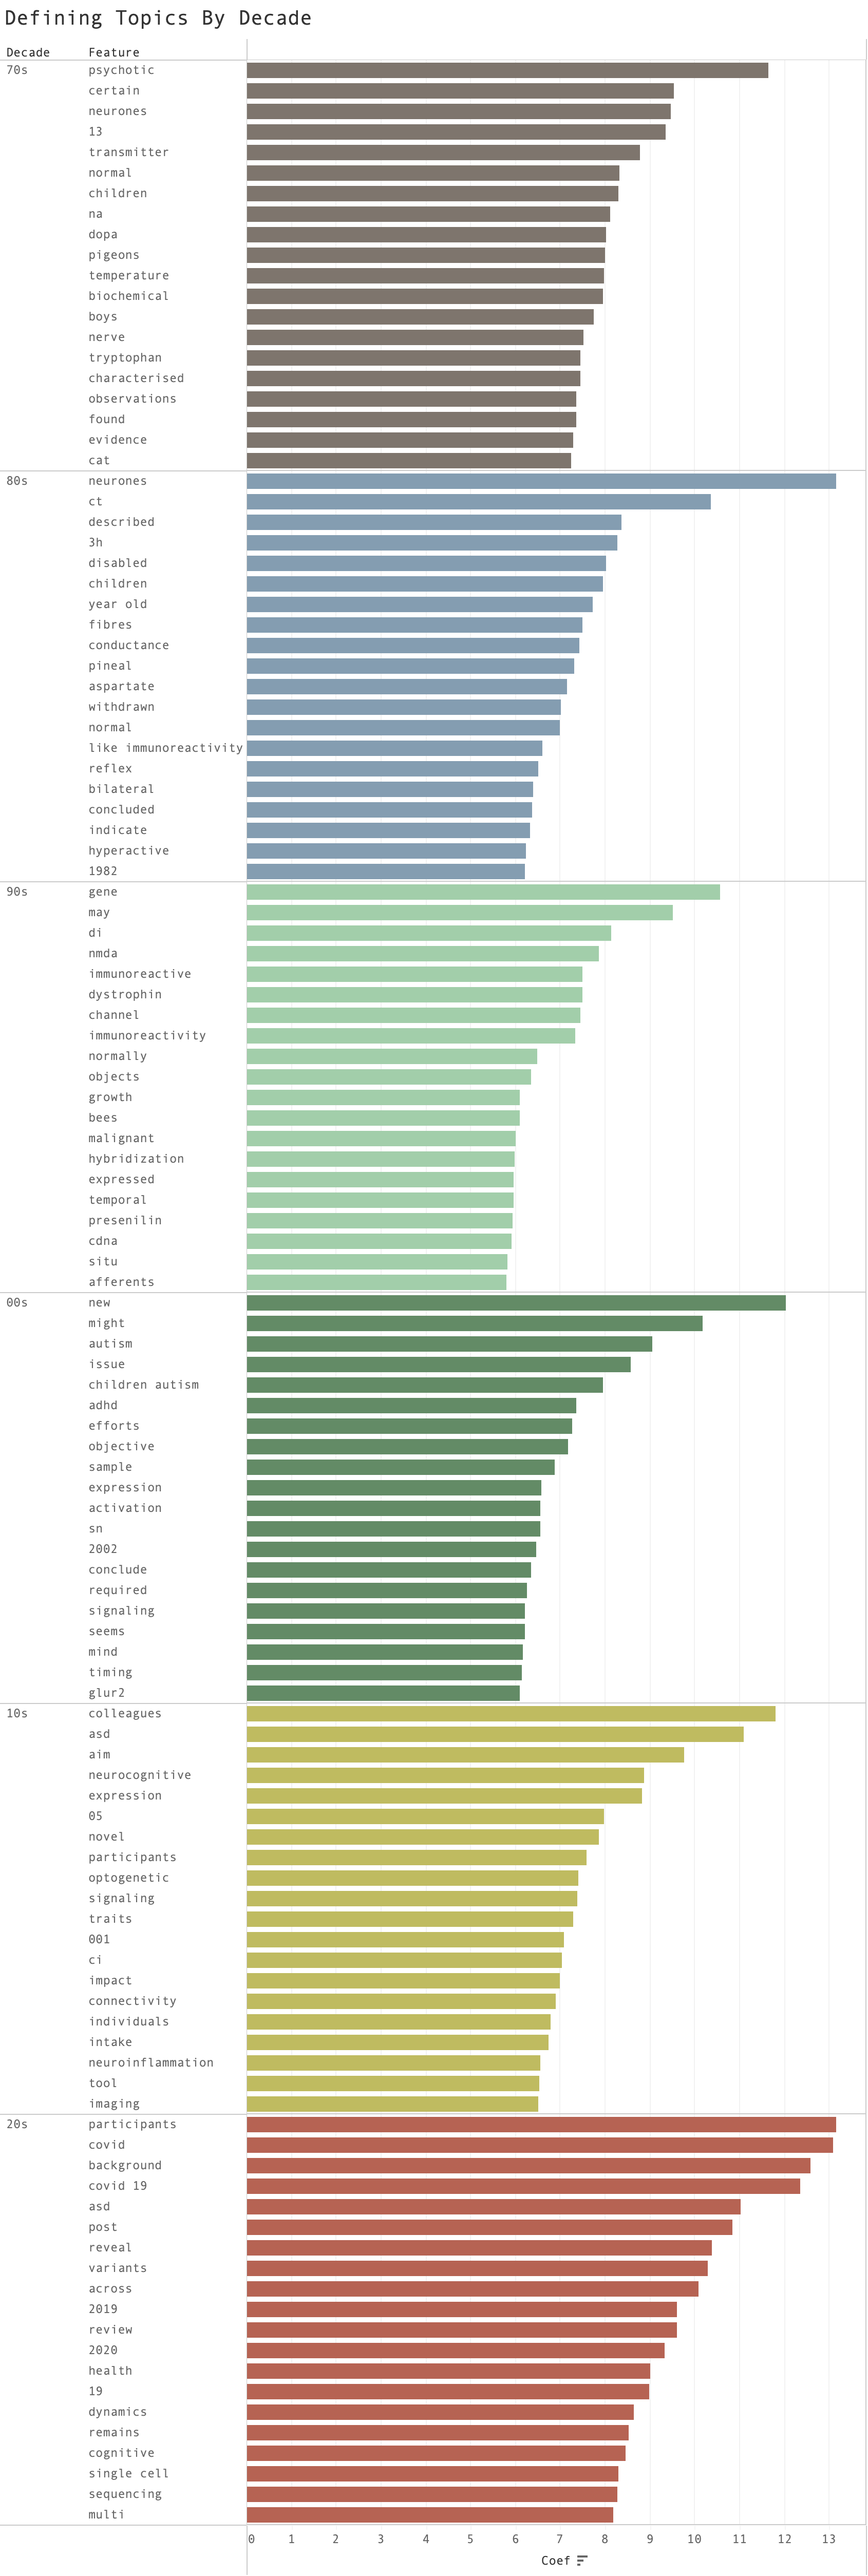

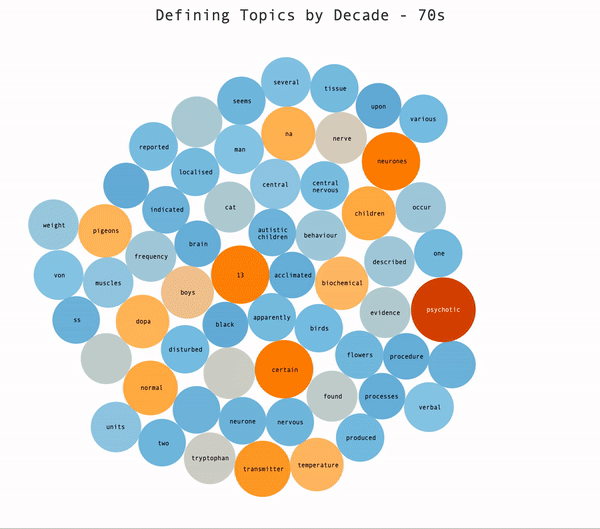